Presence of the following datasets is required.<br>
`./datasets/taskmaster`

In [1]:
# Control whether the network should run on GPU or CPU
USE_CPU=False

In [2]:
import os
import tensorflow as tf

# CPU or GPU
if USE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    # GPU presence check
    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")

In [3]:
!nvidia-smi

Sun Jul 19 08:45:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# import numpy
import numpy as np 
# import pandas
import pandas as pd

# import ktrain
import ktrain
from ktrain import text

In [5]:
import re # for regex

def text_tokens(text):
    # transforming to lowercase
    text = text.lower()
    # replacing whitespace characters with spaces
    text = re.sub("\\s", " ", text)
    # removing everything that is not a letter
    text = re.sub("[^a-zA-Z ']", "", text)
    
    # splitting string into array based on spaces
    tokens = text.split(' ')
    
    # removing empty strings from the tokens array
    tokens = list(filter(('').__ne__, tokens))
    
    return tokens

In [6]:
def taskmasterGetter(path):
    collection = []
    f = open(path, 'r')
    for x in f:
        if '"text":' in x:
            collection.append(text_tokens(x.lstrip()[len('"text": '):]))
            
    return collection

In [7]:
taskmaster = taskmasterGetter('datasets/taskmaster/flights.json') +\
             taskmasterGetter('datasets/taskmaster/food-ordering.json') +\
             taskmasterGetter('datasets/taskmaster/hotels.json') +\
             taskmasterGetter('datasets/taskmaster/movies.json') +\
             taskmasterGetter('datasets/taskmaster/music.json') +\
             taskmasterGetter('datasets/taskmaster/restaurant-search.json') +\
             taskmasterGetter('datasets/taskmaster/sports.json')

In [8]:
import random

def split_data(data):
    X = []
    Y = []
    for i in range(len(data)):
        if (len(data[i]) > 60):
            # too long senteces are cut by default
            X.append(data[i])
            Y.append(0)
        else:
            if (i <= 3*len(data)//4) and (len(data[i]) > 4):
                # picking random point for splitting the conversation turn
                l = random.randrange(1, len(data[i]) - 3)
                # splitting data
                X.append(data[i][:l])
                # adding 0 to the target list -> 0 -- interrupted turn 
                Y.append(0)

            # second half of the dataset is made out of full conversation turns
            else:
                # adding the full uninterrupted conversation turn
                X.append(data[i])
                # adding 1 to the target list -> 1 -- uninterrupted turn 
                Y.append(1)
            
    # shuffling the dataset
    c = list(zip(X, Y, data))
    random.shuffle(c)
    X, Y, data = zip(*c)
    
    return X,Y,data

In [9]:
X, Y, data_clean = split_data(taskmaster)

In [10]:
# naturally ended (= 0, interrupted = 1)
pos = Y 
# artificially ended (= 1, interrupted = 0)
neg = [int(not Y[i]) for i in range(len(data_clean))]


data_join = [' '.join(X[i]) for i in range(len(X))]

In [11]:
# boolan values
# neg = if 1, altered (artificially split)
# pos = if 1, then not altered

d = {'text': data_join, 'neg': neg, 'pos': pos}

In [12]:
df = pd.DataFrame(data=d)

In [13]:
df.head()

,text,neg,pos
0,i'll,1,0
1,let,1,0
2,new york knicks,0,1
3,drake,0,1
4,mj bistro,0,1


---

In [14]:
# preprocessing

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text', # name of column containing text
                                                                   label_columns=['neg', 'pos'],
                                                                   maxlen=60, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.1)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [15]:
# make model

model = text.text_classifier('bert', (x_train, y_train), preproc = preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

Is Multi-Label? False
maxlen is 60
done.


In [16]:
# loads already trained model
LOAD_SAVED=False

In [17]:
if LOAD_SAVED:
    p = ktrain.load_predictor('./saves/BERT_ktrain')
    
else:
    learner.fit_onecycle(2e-5, 1)
    learner.fit_onecycle(2e-5, 1)
    
    p = ktrain.get_predictor(learner.model, preproc)
    
    p.save('./saves/BERT_ktrain')



begin training using onecycle policy with max lr of 2e-05...
Train on 565461 samples, validate on 62829 samples
565461/565461 [==============================] - 16168s 29ms/sample - loss: 0.1998 - accuracy: 0.9186 - val_loss: 0.1680 - val_accuracy: 0.9320


begin training using onecycle policy with max lr of 2e-05...
Train on 565461 samples, validate on 62829 samples
565461/565461 [==============================] - 16026s 28ms/sample - loss: 0.1607 - accuracy: 0.9347 - val_loss: 0.1647 - val_accuracy: 0.9342


---

In [18]:
# pos = positive, that the sentence is complete

data = ['I would like to listen to a song please' , # pos - sentence is complete
        'Could you please open the', # neg - sentence is interrupted
        'What did', # neg - sentence is interrupted
        'What\'s the temperature going to be in two days'] # pos - sentence is complete

p.predict(data)

['neg', 'neg', 'neg', 'pos']

In [19]:
# TIME MEASURING

import time

# ------------
cntr = 0
for i in range(100):
    start = time.time()
    p.predict(['This is something I like but I don\'t know if I']);
    end = time.time()
    
    cntr += np.around(end - start, 8)
# ------------

In [20]:
print(np.around(cntr/100, 8), 'seconds')

0.12131366 seconds


---

### Accuracy analysis based on lenght of the sentences

In [21]:
text = []
neg = []
pos = []
cnt = []

for index, row in df.iterrows():
    if len(row.text) > 0:
        text.append(row.text)
        neg.append(row.neg)
        pos.append(row.pos)
        cnt.append(len(row.text.split()))

In [22]:
d1 = {'text': text, 'cnt': cnt, 'neg': neg, 'pos': pos}
df1 = pd.DataFrame(data=d1)

In [23]:
s = df1.cnt.sort_values().index

In [24]:
df1 = df1.reindex(s)
df1 = df1.reset_index(drop=True)

In [25]:
accuracy = []

for i in range(1,61):
    sentences = list(df1[df1.cnt == i].text)
    neg_data = list(df1[df1.cnt == i].neg)
    results = p.predict(sentences)
    
    tmp = {'text': sentences, 'neg': neg_data, 'res': results}
    tmp1 = pd.DataFrame(data=tmp)
    
    cnt = len(tmp1[((tmp1.neg == 1) & (tmp1.res == 'neg')) | ((tmp1.neg == 0) & (tmp1.res == 'pos'))])
            
    a = cnt/len(neg_data)
    accuracy.append(a)
            
    print('Sentence len:', i, 'accuracy:', a)

Sentence len: 1 accuracy: 0.8962905307920116


Sentence len: 2 accuracy: 0.9645469440751847


Sentence len: 3 accuracy: 0.9571341310049944


Sentence len: 4 accuracy: 0.9474819735422699


Sentence len: 5 accuracy: 0.9704360325826545


Sentence len: 6 accuracy: 0.9732137757724599


Sentence len: 7 accuracy: 0.9798704845127565


Sentence len: 8 accuracy: 0.9809027777777778


Sentence len: 9 accuracy: 0.9863672814755413


Sentence len: 10 accuracy: 0.9859690149079217


Sentence len: 11 accuracy: 0.9884467265725289


Sentence len: 12 accuracy: 0.9881192557722484


Sentence len: 13 accuracy: 0.9873015873015873


Sentence len: 14 accuracy: 0.990632318501171


Sentence len: 15 accuracy: 0.9916267942583732


Sentence len: 16 accuracy: 0.9923508414074452


Sentence len: 17 accuracy: 0.989769820971867


Sentence len: 18 accuracy: 0.9875389408099688


Sentence len: 19 accuracy: 0.9954044117647058


Sentence len: 20 accuracy: 0.9866666666666667


Sentence len: 21 accuracy: 0.9944979367262724


Sentence len: 22 accuracy: 0.988313856427379


Sentence len: 23 accuracy: 0.9877408056042032


Sentence len: 24 accuracy: 0.9840182648401826


Sentence len: 25 accuracy: 0.9794344473007712


Sentence len: 26 accuracy: 0.99375


Sentence len: 27 accuracy: 0.9811320754716981


Sentence len: 28 accuracy: 0.9921568627450981


Sentence len: 29 accuracy: 0.9940119760479041


Sentence len: 30 accuracy: 0.9741935483870968


Sentence len: 31 accuracy: 0.9870967741935484


Sentence len: 32 accuracy: 0.9821428571428571


Sentence len: 33 accuracy: 0.9615384615384616


Sentence len: 34 accuracy: 0.9887640449438202


Sentence len: 35 accuracy: 0.9361702127659575


Sentence len: 36 accuracy: 0.984375


Sentence len: 37 accuracy: 0.9565217391304348


Sentence len: 38 accuracy: 1.0


Sentence len: 39 accuracy: 0.9777777777777777


Sentence len: 40 accuracy: 0.9811320754716981


Sentence len: 41 accuracy: 1.0


Sentence len: 42 accuracy: 1.0


Sentence len: 43 accuracy: 0.9705882352941176


Sentence len: 44 accuracy: 1.0


Sentence len: 45 accuracy: 1.0


Sentence len: 46 accuracy: 1.0


Sentence len: 47 accuracy: 0.9411764705882353


Sentence len: 48 accuracy: 1.0


Sentence len: 49 accuracy: 0.875


Sentence len: 50 accuracy: 0.9285714285714286


Sentence len: 51 accuracy: 1.0


Sentence len: 52 accuracy: 0.9


Sentence len: 53 accuracy: 1.0


Sentence len: 54 accuracy: 1.0


Sentence len: 55 accuracy: 1.0


Sentence len: 56 accuracy: 0.8333333333333334


Sentence len: 57 accuracy: 1.0


Sentence len: 58 accuracy: 0.5


Sentence len: 59 accuracy: 0.0


Sentence len: 60 accuracy: 1.0


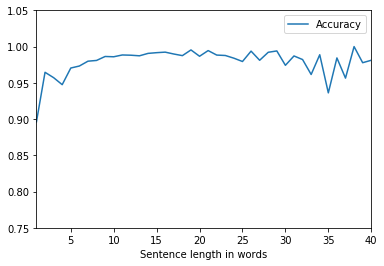

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(1,61), [accuracy[i] for i in range(len(accuracy)) if len], label='Accuracy')
plt.xlim(1,40)
plt.ylim(0.75,1.05)
# plt.plot(l_er, label='Loss')
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

---

## Short sentences check

In [27]:
extract = []
NUM = 25

for i in range(5,16,1):
    extract.append(df1[(df1.cnt == i) & (df1.neg == 1)].head(NUM))
    extract.append(df1[(df1.cnt == i) & (df1.neg == 0)].head(NUM))
    
small_df = pd.concat(extract, axis=0).reset_index(drop=True)

In [28]:
small_df_res = p.predict(np.array(small_df.text))

In [29]:
small_df['predicted'] = small_df_res

In [30]:
# returns the artificially interrupted sentence and its full version
def get_info(string, df):
    cut_index = df[df['text'].str.contains(string)].index[0]
    cut_str = df.at[cut_index,'text']
    
    full_index = tmp[tmp['original text'].str.contains(cut_str)].index[0]
    full_str = tmp.at[full_index, 'original text']

    return cut_str, full_str

In [31]:
def make_test(dfX):
    tt = df1.sample(frac=1)
    tt = tt.reset_index(drop=True)
        
    extract = []
    NUM = 25

    for i in range(5,16,1):
        extract.append(tt[(tt.cnt == i) & (tt.neg == 1)].head(NUM))
        extract.append(tt[(tt.cnt == i) & (tt.neg == 0)].head(NUM))

    small_df = pd.concat(extract, axis=0).reset_index(drop=True)
    small_df_res = p.predict(np.array(small_df.text))
    small_df['predicted'] = small_df_res
    
    S = small_df[((small_df['neg'] == 1) & (small_df['predicted'] == 'pos'))]
    S_ = []

    for index, row in S.iterrows(): S_.append(row.text)
        
    cut_S = []
    full_S = []

    for SENTENCE in S_:
        cut_str, full_str = get_info(SENTENCE, small_df)

        if cut_str != full_str:
            cut_S.append(cut_str)
            full_S.append(full_str)

    df0 = pd.DataFrame(data={'cut': cut_S, 'full': full_S})
    
    dfX = pd.concat([dfX, df0], ignore_index=True)
    
    return dfX

In [33]:
small_df

,text,cnt,neg,pos,predicted
0,yeah you got it hope,5,1,0,neg
1,yes the airlines accommodating dogs,5,1,0,neg
2,yes if you have one,5,1,0,neg
3,i'm going to be leaving,5,1,0,neg
4,actually yes i found a,5,1,0,neg
...,...,...,...,...,...
545,familyrun traditional indian eatery with speci...,15,0,1,pos
546,they last played on august th vs new york city...,15,0,1,pos
547,okay and finally could you tell me the names o...,15,0,1,pos
548,they are not playing next week but they play o...,15,0,1,pos


In [35]:
tmp = pd.DataFrame(data={'original text': [' '.join(i) for i in data_clean]})

In [36]:
get_info('yeah you got it hope', small_df)

('yeah you got it hope', 'yeah you got it hope you enjoy your movie')

### False negatives (falsely classified as non-ended)

In [37]:
small_df[((small_df['neg'] == 0) & (small_df['predicted'] == 'neg'))]

,text,cnt,neg,pos,predicted
79,hi i'm looking for a restaurant,6,0,1,neg
81,and what time would you like,6,0,1,neg
147,okay what other preferences do you have,7,0,1,neg


### False positives (falsely classified as naturally ended)

In [38]:
small_df[((small_df['neg'] == 1) & (small_df['predicted'] == 'pos'))]

,text,cnt,neg,pos,predicted
9,sure for how many people,5,1,0,pos
11,all booked up for you,5,1,0,pos
107,hi what are you looking for today,7,1,0,pos
114,hi i'm looking to find a restaurant,7,1,0,pos
372,okay perfect well that will lead to a wonderfu...,12,1,0,pos
407,i'm looking for a fourstarrated restaurant the...,13,1,0,pos
465,their specials consists of bayou scampi blacke...,14,1,0,pos
469,pan roasted california sturgeon fillet house m...,14,1,0,pos


### Accuracy check

In [39]:
print('Full accuracy:', 1 - (len(small_df[((small_df['neg'] == 0) & (small_df['predicted'] == 'neg'))]) + len(small_df[((small_df['neg'] == 1) & (small_df['predicted'] == 'pos'))]))/len(small_df))
print('\nNegatives accuracy:', 1 - (len(small_df[((small_df['neg'] == 0) & (small_df['predicted'] == 'neg'))]))/(len(small_df)/2))
print('Positives accuracy:', 1 - (len(small_df[((small_df['neg'] == 1) & (small_df['predicted'] == 'pos'))]))/(len(small_df)/2))

Full accuracy: 0.98

Negatives accuracy: 0.9890909090909091
Positives accuracy: 0.9709090909090909
